# Visualization of Attention Map in Alpha-CLIP
This demo only depends on `alpha_clip` to visualize attention map. In original CLIP, when given RGB image, it is model itself to decide focused region. CLIP will, in most cases, focus on the prominent forground object. For Alpha-CLIP, user can define the region need to be focus by providing alpha-map as additional input.

In [2]:
import alpha_clip
from PIL import Image
from torchvision import transforms
import numpy as np
import torch
import math
import torch.nn as nn
import matplotlib.pyplot as plt
from copy import deepcopy

mask_transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Resize((224, 224)),
    transforms.Normalize(0.5, 0.26)
])

device = "cuda:0"
model, preprocess = alpha_clip.load("ViT-L/14", device='cpu', alpha_vision_ckpt_pth="../checkpoints/clip_l14_grit+mim_fultune_6xe.pth", lora_adapt=False, rank=-1)
model = model.float().to(device)

We test a image with multiple objects, image and different mask are prepared. You can test different mask to compare different attention map.

In [3]:
pth = "demo_imgs/attn_image"
class_name = "Loafer" # change the object need focusing from ["crane", "mountain_bike", "suit", "Windsor_tie"]
raw_image = Image.open(pth + "/" + "image.png").convert("RGB")  
wb_mask_pil = Image.open(pth + "/" + class_name + '.png')
wb_mask_image = preprocess.transforms[0](wb_mask_pil)
wb_mask_image = preprocess.transforms[1](wb_mask_image)
wb_mask = np.array(wb_mask_image)

As image input into CLIP is cropped with a squre, we visualize cropped image with corresponding mask as alpha-map input.

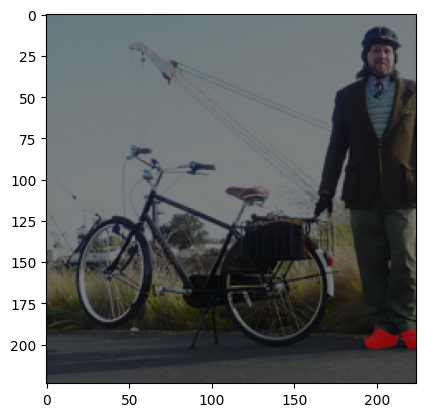

In [4]:
ori_image = preprocess.transforms[0](raw_image)
ori_image = preprocess.transforms[1](ori_image)
mask = deepcopy(wb_mask)
mask[:, :, 1:] = 0
ori_image = (np.array(ori_image) * 0.5 + mask * 0.5).astype(np.uint8)
ori_image = np.array(ori_image)
plt.imshow(ori_image)

In [ ]:
binary_mask = (wb_mask[:, :, 0] == 255)
alpha = mask_transform((binary_mask * 255).astype(np.uint8))
alpha = alpha.cuda().unsqueeze(dim=0)
mask = alpha
image = preprocess(raw_image).unsqueeze(0).to(device)
with torch.no_grad():
    image_features, attention_last = model.visual(image, mask, return_attn=True)
    attentions = attention_last.unsqueeze(dim=0)

We follow [DINO](https://github.com/facebookresearch/dino) to visualize the attention map with interpolation.

In [6]:
nh = attentions.shape[1]
attentions = attentions[0, :, 0, 1:].reshape(nh, -1)
p_s = int(math.sqrt(attentions.shape[1]))
attentions = attentions.reshape(nh, p_s, p_s)
attentions = nn.functional.interpolate(attentions.unsqueeze(0), scale_factor=int((224//p_s)), mode="nearest")[0].cpu().numpy()

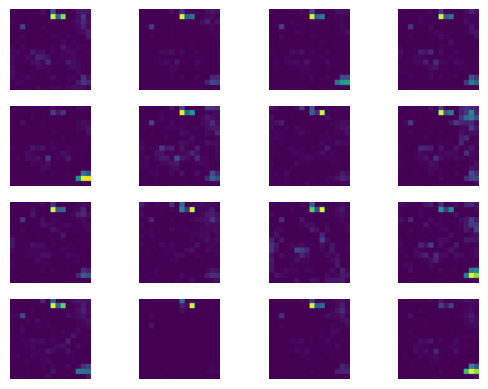

In [7]:
for j in range(nh):
    plt.subplot(4, 4, j+1)
    plt.axis('off')
    plt.imshow(attentions[j])